In [1]:
! pip install -r requirements.txt

In [99]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
import glob
from collections import defaultdict
import datetime
import pytz
from astral import LocationInfo
from astral.sun import sun
import seaborn as sns
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
warnings.filterwarnings('ignore')

In [79]:
path =  "./data"
relPathApart =  f"{path}/apartment"
relPathWeather = f"{path}/apartment-weather"
year = 2016
aptNum = 114
startDate = '2016-02-01' # '2016-02-01'
endDate = '2016-03-03' # '2016-03-03'
granularity = "1h"
randomState = 2024

In [4]:
! mkdir -p "./data"
! wget -nc "https://lass.cs.umass.edu/smarttraces/2017/apartment-electrical.tar.gz" -P "./data"
! wget -nc "https://lass.cs.umass.edu/smarttraces/2017/apartment-weather.tar.gz" -P "./data"

File ‘./data/apartment-electrical.tar.gz’ already there; not retrieving.

File ‘./data/apartment-weather.tar.gz’ already there; not retrieving.



In [5]:
! tar -xf "./data/apartment-electrical.tar.gz" -C "./data"
! tar -xf "./data/apartment-weather.tar.gz" -C "./data"

In [6]:
apartDfs = []
allFiles = glob.glob(f"{relPathApart}/{year}/*.csv")
for fileName in allFiles:
  df = pd.read_csv(fileName, parse_dates=[1], header=None, names=['date', 'power'])
  df["power"] = df["power"].astype(float)
  apartDfs.append(df)

print(apartDfs)

[                       date     power
0       2016-01-01 00:00:00  0.588867
1       2016-01-01 00:01:00  0.418467
2       2016-01-01 00:02:00  0.203583
3       2016-01-01 00:03:00  0.203600
4       2016-01-01 00:04:00  0.203600
...                     ...       ...
503770  2016-12-15 20:10:00  0.005217
503771  2016-12-15 20:11:00  0.005467
503772  2016-12-15 20:12:00  0.004733
503773  2016-12-15 20:13:00  0.004733
503774  2016-12-15 20:14:00  0.004667

[503775 rows x 2 columns],                        date     power
0       2016-01-01 00:00:00  0.386450
1       2016-01-01 00:01:00  0.386850
2       2016-01-01 00:02:00  0.386000
3       2016-01-01 00:03:00  0.386633
4       2016-01-01 00:04:00  0.386017
...                     ...       ...
503785  2016-12-15 20:25:00  0.440067
503786  2016-12-15 20:26:00  0.440383
503787  2016-12-15 20:27:00  0.440900
503788  2016-12-15 20:28:00  0.441033
503789  2016-12-15 20:29:00  0.441250

[503790 rows x 2 columns],                        date    

In [7]:
for i in range(len(apartDfs)):
  apartDfs[i] = apartDfs[i].loc[(apartDfs[i]['date'] > startDate) & (apartDfs[i]['date'] < endDate)]
  assert(len(apartDfs[i]) == len(apartDfs[0]))

                         date         power
0   2016-02-01 00:00:00-05:00  10360.396733
1   2016-02-01 01:00:00-05:00   9570.685767
2   2016-02-01 02:00:00-05:00   9363.859150
3   2016-02-01 03:00:00-05:00   9356.058217
4   2016-02-01 04:00:00-05:00   9172.311817
..                        ...           ...
739 2016-03-02 19:00:00-05:00  15253.919833
740 2016-03-02 20:00:00-05:00  16657.333417
741 2016-03-02 21:00:00-05:00  16436.806817
742 2016-03-02 22:00:00-05:00  15470.794233
743 2016-03-02 23:00:00-05:00  15467.426950

[744 rows x 2 columns]


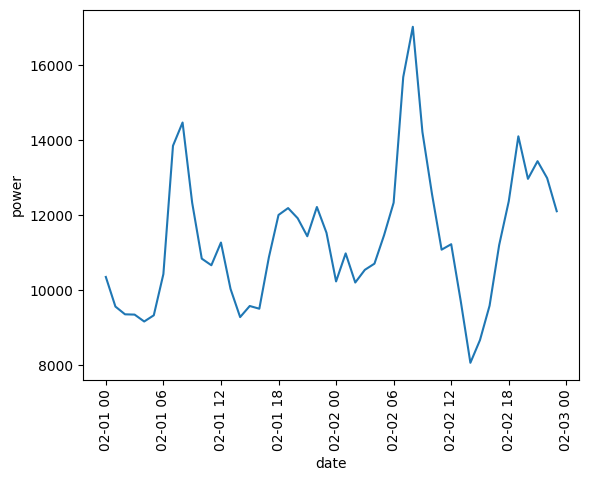

In [160]:
# Aggregate data of all the apartment
powerDf = pd.concat(apartDfs).groupby("date").sum().reset_index()
powerDf["date"] = pd.to_datetime(powerDf["date"]).dt.tz_localize(pytz.timezone('US/Eastern'))

# Perform granularity modification
powerDf = powerDf.resample(granularity, on="date").sum().reset_index()
powPlot = sns.lineplot(data=powerDf[powerDf["date"] < '2016-02-03'], x="date", y="power")
powPlot.set_xticklabels(powPlot.get_xticklabels(), rotation=90)
print(powerDf)

In [64]:
# Include weather data
def dateparse (time_in_secs):
    # Set the correct timezone
    dateTime = datetime.datetime.fromtimestamp(float(time_in_secs), tz=pytz.timezone('US/Eastern'))    
    return dateTime

print(pytz.timezone('US/Eastern'))
filePath = f"{relPathWeather}/apartment{year}.csv"
weathDf = pd.read_csv(filePath, parse_dates=["time"], date_parser=dateparse)
weathDf = weathDf.drop(columns=["icon", "cloudCover"])


print(weathDf)

US/Eastern
      temperature  humidity  visibility        summary  apparentTemperature  \
0           36.00      0.63       10.00          Clear                29.75   
1           35.73      0.62       10.00  Mostly Cloudy                29.39   
2           35.35      0.62       10.00          Clear                29.21   
3           35.19      0.63       10.00          Clear                30.21   
4           35.33      0.63       10.00          Clear                29.40   
...           ...       ...         ...            ...                  ...   
8779        29.62      0.71       10.00          Clear                24.18   
8780        26.61      0.78       10.00          Clear                26.61   
8781        24.42      0.82       10.00          Clear                18.56   
8782        23.20      0.85        9.89          Clear                23.20   
8783        22.50      0.87        9.23          Clear                22.50   

      pressure  windSpeed               

In [65]:
# Perform a join using the "nearest" datetime instead of the exactly matching one
powerWeathDf = pd.merge_asof(powerDf, weathDf, left_on="date", right_on="time", direction="nearest")
powerWeathDf.drop(columns=["time"], inplace=True)

print(powerWeathDf)

                         date         power  temperature  humidity  \
0   2016-02-01 00:00:00-05:00  10360.396733        39.49      0.71   
1   2016-02-01 01:00:00-05:00   9570.685767        38.19      0.76   
2   2016-02-01 02:00:00-05:00   9363.859150        38.94      0.77   
3   2016-02-01 03:00:00-05:00   9356.058217        38.26      0.80   
4   2016-02-01 04:00:00-05:00   9172.311817        38.16      0.81   
..                        ...           ...          ...       ...   
739 2016-03-02 19:00:00-05:00  15253.919833        25.50      0.52   
740 2016-03-02 20:00:00-05:00  16657.333417        24.32      0.53   
741 2016-03-02 21:00:00-05:00  16436.806817        23.36      0.51   
742 2016-03-02 22:00:00-05:00  15470.794233        22.41      0.51   
743 2016-03-02 23:00:00-05:00  15467.426950        21.82      0.50   

     visibility summary  apparentTemperature  pressure  windSpeed  \
0          10.0   Clear                34.94   1007.92       6.32   
1          10.0   Cle

In [66]:
# Add calendar information (day of the week, day of the month, hour of the day, period of the day (night time of daytime) and is weekend (boolean))
def dotwFromDatetime(date: datetime.datetime):
    return date.weekday()

def dotmFromDatetime(date: datetime.datetime):
    return date.day

def hotdFromDatetime(date: datetime.datetime):
    return date.hour

def potdFromDatetime(date: datetime.datetime):
    city = LocationInfo("Amherst", "USA")
    s = sun(city.observer, date=date.date())
    sunrise = s['sunrise']
    sunset = s['sunset']

    return "day" if sunrise <= date <= sunset else "night"

def isWeFromDatetime(date: datetime.datetime):
    # Saturday and Sunday are respectively 5 and 6
    return False if date.weekday() < 5 else True

powerWeathDf['dayOfWeek'] = powerWeathDf['date'].apply(dotwFromDatetime)
powerWeathDf['dayOfMonth'] = powerWeathDf['date'].apply(dotmFromDatetime)
powerWeathDf['hourOfDay'] = powerWeathDf['date'].apply(hotdFromDatetime)
powerWeathDf['periodOfDay'] = powerWeathDf['date'].apply(potdFromDatetime)
powerWeathDf['isWeekend'] = powerWeathDf['date'].apply(isWeFromDatetime)

<Axes: >

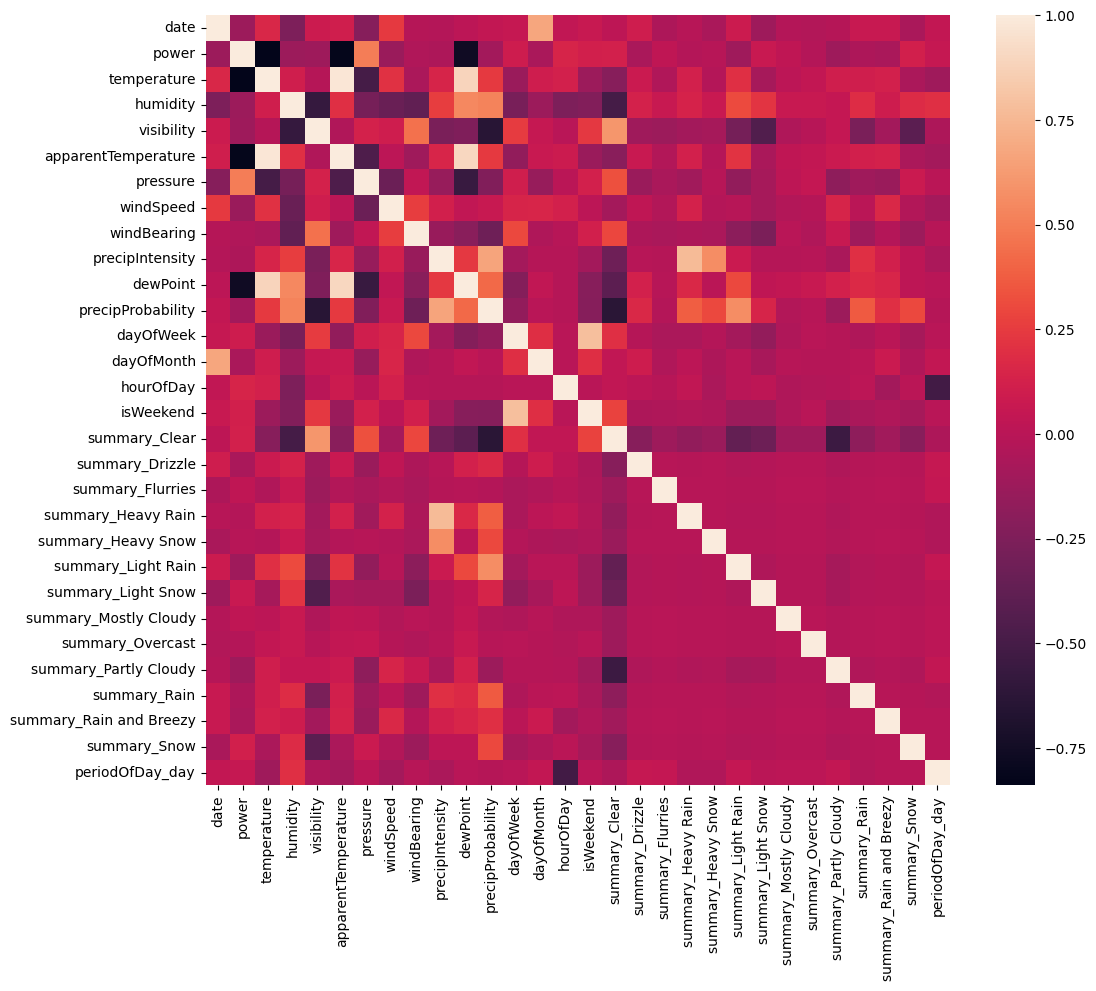

In [67]:
# Encode the categorical columns of the df
powerWeathEncDf = pd.get_dummies(powerWeathDf)
powerWeathEncDf = powerWeathEncDf.drop(columns=["periodOfDay_night"])

# Plot correlation matrix heatmap
plt.subplots(figsize=(12,10))
sns.heatmap(powerWeathEncDf.corr())

In [154]:
# TODO Perform Recursive Feature Elimination with Random Forest as backend model
minFeat = 1
clf = RandomForestRegressor()
cv = KFold(n_splits=5)

rfecv = RFECV(
    estimator=clf,
    step=1,
    scoring="explained_variance",
    cv=cv,
    verbose=True,
    min_features_to_select=minFeat,
    n_jobs=8,
)

X = powerWeathEncDf.drop(columns=["date", "power"])
Y = powerWeathEncDf["power"]

rfecv.fit(X, Y)

print(f"Optimal number of features: {rfecv.n_features_}")

Fitting estimator with 28 features.
Fitting estimator with 28 features.
Fitting estimator with 28 features.
Fitting estimator with 28 features.
Fitting estimator with 28 features.
Fitting estimator with 27 features.
Fitting estimator with 27 features.
Fitting estimator with 27 features.
Fitting estimator with 27 features.
Fitting estimator with 27 features.
Fitting estimator with 26 features.
Fitting estimator with 26 features.
Fitting estimator with 26 features.
Fitting estimator with 26 features.
Fitting estimator with 26 features.
Fitting estimator with 25 features.
Fitting estimator with 25 features.
Fitting estimator with 25 features.
Fitting estimator with 25 features.
Fitting estimator with 25 features.
Fitting estimator with 24 features.
Fitting estimator with 24 features.
Fitting estimator with 24 features.
Fitting estimator with 24 features.
Fitting estimator with 24 features.
Fitting estimator with 23 features.
Fitting estimator with 23 features.
Fitting estimator with 23 fe

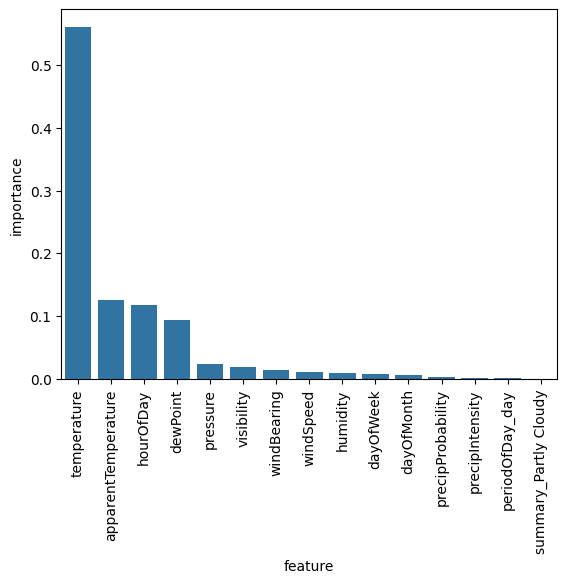

Text(0.5, 0, 'Number of features')

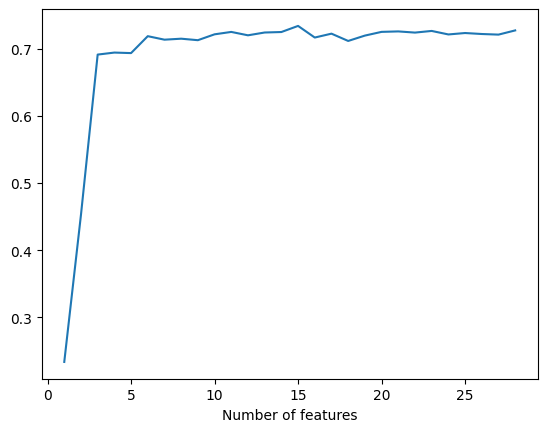

In [155]:
selFeat = pd.DataFrame(columns=["feature", "importance"])
i = 0
for selFeatIdx, col in zip(rfecv.support_, X.columns):
    if selFeatIdx:
        selFeat.loc[len(selFeat)] = {"feature": col, "importance": rfecv.estimator_.feature_importances_[i]}
        i += 1

selFeat.sort_values(by="importance", inplace=True, ascending=False)


barPlot = sns.barplot(data=selFeat, x="feature", y="importance")
barPlot.set_xticklabels(barPlot.get_xticklabels(), rotation=90)
plt.show()

testScores = rfecv.cv_results_["mean_test_score"]
scoresPlot = sns.lineplot(x=rfecv.cv_results_["n_features"], y=testScores)
scoresPlot.set_xlabel("Number of features")

In [147]:
rfecv.cv_results_

{'mean_test_score': array([0.05266631, 0.26454159, 0.64563301, 0.61014295, 0.61659903,
        0.67164103, 0.67304801, 0.65744493, 0.64215747, 0.65020982,
        0.67017633, 0.66180701, 0.67930958, 0.66196889, 0.65733038,
        0.66529045, 0.65759981, 0.65455938, 0.66040346, 0.65827244,
        0.67687698, 0.67556936, 0.6690319 , 0.67170042, 0.66166405,
        0.64792052, 0.66776268, 0.67007919]),
 'std_test_score': array([0.2069302 , 0.35716709, 0.10964944, 0.16420473, 0.13097829,
        0.09856664, 0.11358964, 0.12512046, 0.161169  , 0.15650771,
        0.12296331, 0.13584391, 0.12437933, 0.1261354 , 0.14770329,
        0.13906535, 0.12400998, 0.15326733, 0.13159464, 0.14356415,
        0.10684386, 0.11052248, 0.12379362, 0.11537168, 0.1196331 ,
        0.15447665, 0.13117987, 0.12036467]),
 'split0_test_score': array([-0.23697436, -0.38553354,  0.44462288,  0.63849009,  0.68605031,
         0.72953321,  0.77925898,  0.7232519 ,  0.75154097,  0.76491332,
         0.76480622,  0.